In [1]:
LMDB_FILEPATH_TRAIN = "/mnt/data_ssd/lmdb/seefood_train_data"
LMDB_FILEPATH_TEST = "/mnt/data_ssd/lmdb/seefood_test_data"

## Imports

In [2]:
%load_ext lab_black

In [3]:
%load_ext google.cloud.bigquery
%load_ext line_profiler

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import sys

sys.path.insert(0, "../..")

In [6]:
import time
import copy

import pandas as pd
import numpy as np
import altair as alt
import lmdb
import pickle
import os
import string

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split

from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.tensorboard import SummaryWriter
from PIL import Image, ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [7]:
def get_metrics(name, y_test, y_pred):
    return pd.DataFrame(
        {
            "experiment_name": name,
            "r2_score": [r2_score(y_test, y_pred)],
            "explained_variance_score": [explained_variance_score(y_test, y_pred)],
            "max_error": [max_error(y_test, y_pred)],
            "mean_absolute_error": [mean_absolute_error(y_test, y_pred)],
            "mean_squared_error": [mean_squared_error(y_test, y_pred)],
            "median_absolute_error": [median_absolute_error(y_test, y_pred)],
        }
    )

## Load data

In [8]:
%%bigquery df_nn --project zenscr-seefood-dev

SELECT title, total_calories
FROM `zenscr-seefood-dev.sparkrecipes.base_filtered`
INNER JOIN `zenscr-seefood-dev.sparkrecipes.image_path`
USING (recipe_id)

In [9]:
df_nn

,title,total_calories
0,Fruit Cocktail Dessert/Salad,30.0
1,Fruit Cocktail Dessert/Salad,30.0
2,Fruit Cocktail Dessert/Salad,30.0
3,Fruit Cocktail Dessert/Salad,30.0
4,Fruit Cocktail Dessert/Salad,30.0
...,...,...
1311732,Banana Bread Muffins,134.9
1311733,Banana Bread Muffins,134.9
1311734,Banana Bread Muffins,134.9
1311735,Banana Bread Muffins,134.9


In [10]:
df_nn.describe()

,total_calories
count,1.311737e+06
mean,2.190868e+02
std,1.085666e+02
min,2.560000e+01
25%,1.350000e+02
50%,2.049000e+02
75%,2.912000e+02
max,5.217000e+02


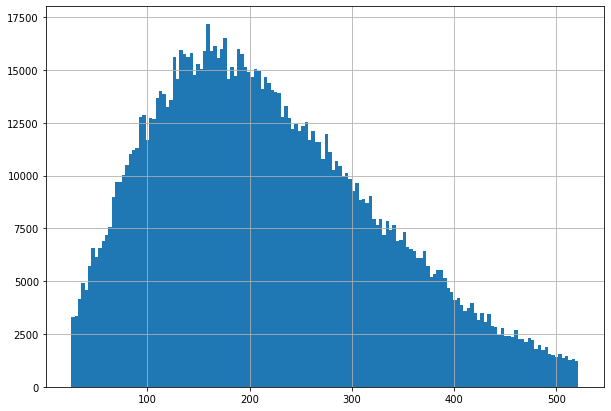

In [11]:
_ = df_nn.total_calories.hist(bins=150, figsize=(10, 7))

# Train Neural Network

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [13]:
cpu = torch.device("cpu")

In [14]:
IMAGE_SIZE = 224


class Features:
    def __init__(self, features, target):
        self.shape = features.shape
        self.features = features.numpy().tobytes()
        self.target = target.round().item()

    def get_features(self):
        features = np.frombuffer(self.features, dtype=np.float32)
        return torch.from_numpy(features.reshape(self.shape))


class LMDBDataset(torch.utils.data.Dataset):
    def __init__(self, lmdb_filename):
        self.env = lmdb.open(
            lmdb_filename,
            max_readers=1,
            readonly=True,
            lock=False,
            readahead=False,
            meminit=False,
        )
        print(self.env.stat())
        with self.env.begin(write=False) as txn:
            self.length = txn.stat()["entries"]

    def __getitem__(self, index):
        with self.env.begin(write=False) as txn:
            key = f"{index:08}".encode("ascii")
            buf = txn.get(key)

        features = pickle.loads(buf)
        return features.get_features(), np.log1p(features.target)

    def __len__(self):
        return self.length


class CalorieNet(nn.Module):
    """ Predicts calories given an image displaying food """

    def __init__(self):
        super(CalorieNet, self).__init__()
        self.regressor = nn.Sequential(
            nn.Dropout(0.2), nn.Linear(1280, 512), nn.Linear(512, 1)
        )

    def forward(self, x):
        y = self.regressor(x)
        y = y.squeeze()
        return y

In [15]:
image_datasets = {
    "train": LMDBDataset(LMDB_FILEPATH_TRAIN),
    "val": LMDBDataset(LMDB_FILEPATH_TEST),
}

dataloaders = {
    "train": torch.utils.data.DataLoader(
        image_datasets["train"],
        batch_size=64,
        shuffle=True,
        num_workers=4,
        pin_memory=False,
    ),
    "val": torch.utils.data.DataLoader(
        image_datasets["val"],
        batch_size=64,
        shuffle=False,
        num_workers=4,
        pin_memory=False,
    ),
}

dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val"]}

{'psize': 4096, 'depth': 3, 'branch_pages': 27, 'leaf_pages': 5671, 'overflow_pages': 1757726, 'entries': 878863}
{'psize': 4096, 'depth': 3, 'branch_pages': 14, 'leaf_pages': 2793, 'overflow_pages': 865748, 'entries': 432874}


In [16]:
device

device(type='cuda', index=0)

In [17]:
net = CalorieNet().to(device)

In [18]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    writer = SummaryWriter()
    since = time.time()
    training_loss = []
    validation_loss = []

    for epoch in tqdm(range(num_epochs)):
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
            running_loss = 0.0

            i = 0
            for inputs, targets in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                targets = targets.to(device)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)

            if phase == "train":
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            if phase == "train":
                training_loss.append(epoch_loss)
                writer.add_scalar("Loss/train", epoch_loss, epoch)
            else:
                validation_loss.append(epoch_loss)
                writer.add_scalar("Loss/val", epoch_loss, epoch)

    time_elapsed = time.time() - since

    print(f"Training complete in {time_elapsed/60}m {time_elapsed % 60}s")
    writer.close()
    return model, (training_loss, validation_loss)

In [20]:
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [21]:
model, metrics = train_model(net, criterion, optimizer, exp_lr_scheduler, num_epochs=20)



Training complete in 11.853928629557291m 51.2357177734375s


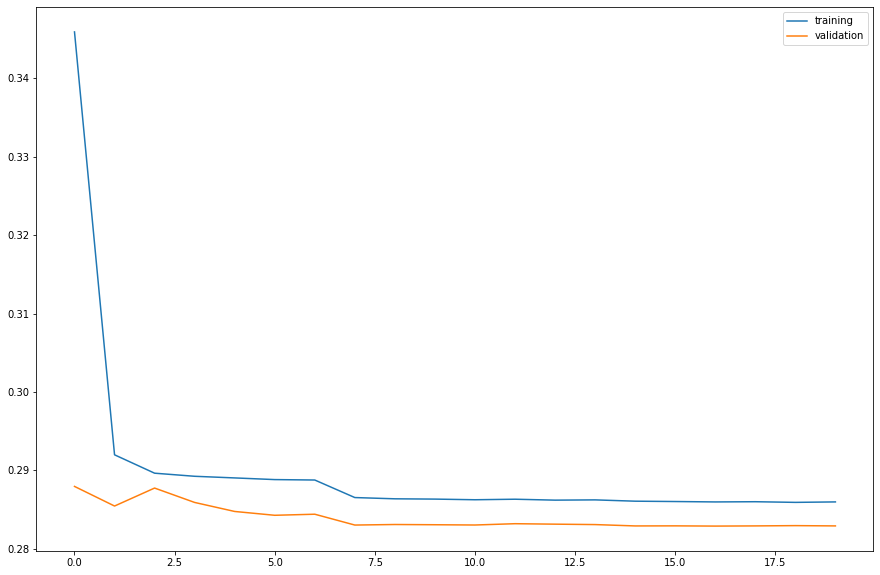

In [22]:
training_loss, validation_loss = metrics
pd.DataFrame({"training": training_loss, "validation": validation_loss}).plot.line(
    figsize=(15, 10)
)

In [50]:
predict_dataloader = torch.utils.data.DataLoader(
    LMDBDataset(LMDB_FILEPATH_TEST), batch_size=100, shuffle=False, num_workers=0,
)

y_train_dataloader = torch.utils.data.DataLoader(
    LMDBDataset(LMDB_FILEPATH_TRAIN), batch_size=100, shuffle=False, num_workers=0,
)

{'psize': 4096, 'depth': 3, 'branch_pages': 14, 'leaf_pages': 2793, 'overflow_pages': 865748, 'entries': 432874}
{'psize': 4096, 'depth': 3, 'branch_pages': 27, 'leaf_pages': 5671, 'overflow_pages': 1757726, 'entries': 878863}


In [28]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [29]:
set_parameter_requires_grad(model, True)

In [30]:
y_pred_nn = []
y_true_nn = []

for inputs, targets in predict_dataloader:
    inputs = inputs.to(device)
    out = model(inputs)
    y_pred_nn.append(out.to(cpu))
    y_true_nn.append(targets)

In [51]:
y_train = []
for _, targets in y_train_dataloader:
    y_train.append(targets)

In [52]:
y_pred_nn_np = np.expm1(torch.flatten(torch.cat(y_pred_nn)).detach().numpy())
y_true_nn_np = np.expm1(torch.flatten(torch.cat(y_true_nn)).detach().numpy())
y_train_np = np.expm1(torch.flatten(torch.cat(y_train)).detach().numpy())

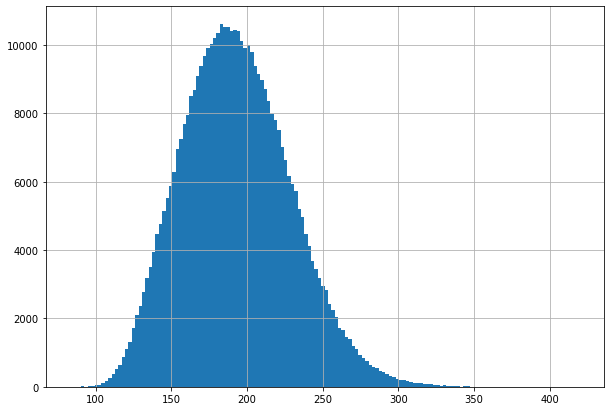

In [53]:
pd.Series(y_pred_nn_np).hist(bins=150, figsize=(10, 7))

In [54]:
df_nn_results = get_metrics("nn", y_true_nn_np, y_pred_nn_np)
df_nn_results

,experiment_name,r2_score,explained_variance_score,max_error,mean_absolute_error,mean_squared_error,median_absolute_error
0,nn,0.057609,0.114954,391.03244,82.384232,11099.828125,67.507683


## Create Baseline

In [55]:
from sklearn.base import BaseEstimator
from sklearn.base import RegressorMixin
from sklearn.utils.validation import check_is_fitted


class BaselineModel(BaseEstimator, RegressorMixin):
    def __init__(self):
        pass

    def fit(self, _, y):
        self.mean_ = y.mean()
        return self

    def predict(self, X):
        check_is_fitted(self, [])

        return np.array(X.shape[0] * [self.mean_])

In [56]:
baseline_model = BaselineModel()

In [57]:
baseline_model.fit(None, y_train_np)

BaselineModel()

In [61]:
y_pred_baseline = baseline_model.predict(pd.Series(y_true_nn_np))

In [62]:
df_baseline_results = get_metrics("baseline", y_true_nn_np, y_pred_baseline)
df_baseline_results

,experiment_name,r2_score,explained_variance_score,max_error,mean_absolute_error,mean_squared_error,median_absolute_error
0,baseline,-0.000002,0.0,302.962433,88.863808,11778.392578,79.037613


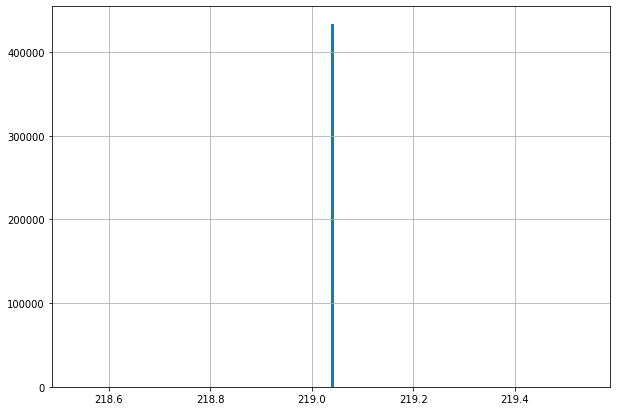

In [67]:
pd.Series(y_pred_baseline).hist(bins=150, figsize=(10, 7))

## Compare NN to Baseline

In [63]:
df_results = pd.concat([df_baseline_results, df_nn_results]).reset_index(drop=True).T
df_results.columns = df_results.loc["experiment_name"].values
df_results = df_results.iloc[1:]

In [64]:
df_results

,baseline,nn
r2_score,-1.96215e-06,0.0576092
explained_variance_score,0,0.114954
max_error,302.962,391.032
mean_absolute_error,88.8638,82.3842
mean_squared_error,11778.4,11099.8
median_absolute_error,79.0376,67.5077


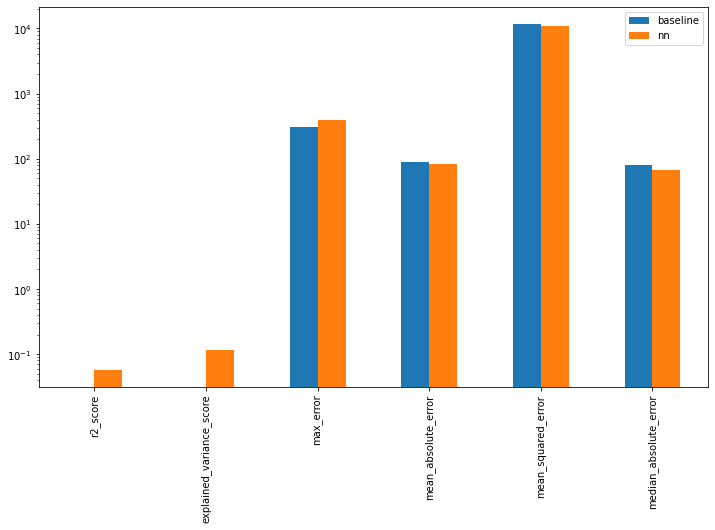

In [66]:
df_results.plot.bar(log=True, figsize=(12, 7))

## Inspect predictions

In [69]:
df_predictions = pd.DataFrame({"y_pred": y_pred_nn_np, "y_true": y_true_nn_np})
df_predictions

,y_pred,y_true
0,167.683807,85.999992
1,183.236176,291.000061
2,194.717422,240.000015
3,153.477737,173.999985
4,191.151123,147.000015
...,...,...
432869,220.224503,161.000015
432870,190.310211,197.000015
432871,146.963821,95.000000
432872,188.012329,141.000031


In [1]:
df_predictions_sample = df_predictions.sample(5000)
line = alt.Chart(df_predictions_sample).mark_line().encode(x="y_true", y="y_true")

scatter = (
    alt.Chart(df_predictions_sample)
    .mark_circle(color="red")
    .encode(x="y_pred", y="y_true", tooltip=["y_pred", "y_true"],)
).interactive()

(line + scatter).properties(width=600, height=600)

NameError: name 'df_predictions' is not defined

In [ ]:
NON_FEATURE_COLS = ["title", "total_calories", "servings", "predicted_calories"]

In [ ]:
df_high_cal = df_predictions[df_predictions.predicted_calories > 300]
df_low_cal = df_predictions[df_predictions.predicted_calories < 120]

In [ ]:
df_high_cal[NON_FEATURE_COLS].sample(10)

In [ ]:
df_low_cal[NON_FEATURE_COLS].sample(10)

In [ ]:
df_high_cal[NON_FEATURE_COLS].describe()

In [ ]:
df_low_cal[NON_FEATURE_COLS].describe()

In [ ]:
high_cal_wc = WordCloud().generate(" ".join(df_high_cal.title.str.lower()))
low_cal_wc = WordCloud().generate(" ".join(df_low_cal.title.str.lower()))

In [ ]:
plt.figure(figsize=(15, 15))
plt.imshow(high_cal_wc, interpolation="nearest")

In [ ]:
plt.figure(figsize=(15, 15))
plt.imshow(low_cal_wc, interpolation="nearest")

# Persist Model

In [ ]:
!ls ../../models

In [44]:
torch.save(model, "../../models/calorie_regression_mobilenet.pt")

/home/mike/.cache/pypoetry/virtualenvs/seefood-nC6BBDGh-py3.8/lib/python3.8/site-packages/torch/serialization.py:359: UserWarning: Couldn't retrieve source code for container of type CalorieNet. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "
